Net2(
  (mlp): ModuleList(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
    (3): ReLU()
  )
)


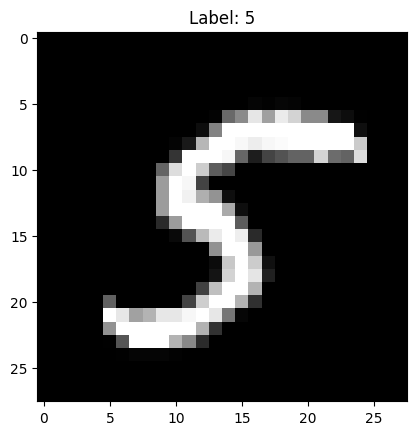

mlp.0.weight Parameter containing:
tensor([[ 0.0007, -0.0054,  0.0186,  ..., -0.0355, -0.0066,  0.0238],
        [ 0.0138, -0.0142, -0.0025,  ...,  0.0157,  0.0181, -0.0013],
        [ 0.0129,  0.0315, -0.0323,  ...,  0.0314,  0.0048,  0.0193],
        ...,
        [-0.0008, -0.0115,  0.0028,  ..., -0.0113,  0.0163, -0.0349],
        [-0.0357,  0.0174,  0.0125,  ..., -0.0237, -0.0171, -0.0292],
        [ 0.0317,  0.0198,  0.0214,  ..., -0.0088,  0.0188,  0.0158]],
       requires_grad=True) torch.Size([30, 784])
mlp.0.bias Parameter containing:
tensor([ 0.0230, -0.0200, -0.0143,  0.0213,  0.0061, -0.0348,  0.0179,  0.0081,
         0.0122,  0.0136,  0.0330, -0.0206, -0.0285, -0.0337,  0.0169,  0.0321,
         0.0204,  0.0292, -0.0018,  0.0086,  0.0070,  0.0098,  0.0197, -0.0059,
        -0.0236, -0.0168,  0.0319, -0.0296,  0.0266,  0.0286],
       requires_grad=True) torch.Size([30])
mlp.2.weight Parameter containing:
tensor([[-7.8807e-02, -1.5542e-01,  2.4377e-02,  1.5134e-01,  5.396

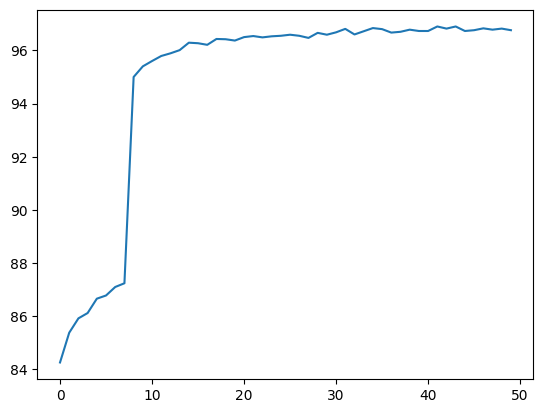

In [1]:
from pathlib import Path
import pickle
import gzip
import random
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from warmup_scheduler import GradualWarmupScheduler

# 加载mnist.pkl.gz
def load_data_pickle(data_path, filename, batchSize):
    # 解压缩数据集
    with gzip.open((PATH/FILENAME).as_posix(),"rb") as f:
        ((x_train,y_train),(x_valid,y_valid),(x_test,y_test))=pickle.load(f,encoding="iso-8859-1")
    #x_train(50000,784),y_train(50000,) x_valid(10000, 784),y_valid(10000,) x_test(10000, 784),y_test(10000,)
    #=================数据转为tensor才能参与建模训练===
    x_train,y_train,x_valid,y_valid,x_test,y_test=map(torch.tensor, (x_train,y_train,x_valid,y_valid,x_test,y_test))
    train_loader = DataLoader(TensorDataset(x_train,y_train), 
                              shuffle=True, 
                              batch_size=batchSize, 
                              drop_last=True)
    valid_loader = DataLoader(TensorDataset(x_valid,y_valid), 
                              shuffle=True, 
                              batch_size=batchSize, 
                              drop_last=True)
    test_loader = DataLoader(TensorDataset(x_test,y_test), 
                             shuffle=True, 
                             batch_size=batchSize, 
                              drop_last=False)
    
    return train_loader, valid_loader, test_loader

# 加载mnist datasets
def load_data(data_path, batchSize):
    transform=transforms.Compose([
        transforms.ToTensor(),
        #均值=0.1307，标准差=0.3081
        transforms.Normalize((0.1307,),(0.3081,))
    ])
    trainset=datasets.MNIST(root=data_path, 
                            train=True, 
                            download=True, 
                            transform=transform)
    test_dataset=datasets.MNIST(root=data_path, 
                                train=False, 
                                download=True, 
                                transform=transform)
    
    # 将训练集分为训练和验证集
    train_size = int(0.8 * len(trainset))
    valid_size = len(trainset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(trainset, [train_size, valid_size])
    
    train_loader=DataLoader(train_dataset, 
                            shuffle=True, 
                            batch_size=batchSize, 
                            drop_last=True)
    valid_loader=DataLoader(valid_dataset, 
                            shuffle=True, 
                            batch_size=batchSize, 
                            drop_last=True)
    test_loader=DataLoader(test_dataset, 
                           shuffle=True, 
                           batch_size=batchSize, 
                            drop_last=False)
    
    return train_loader, valid_loader, test_loader

# 验证数据集，随机显示数字
def showRandomPictures(data_loader):
    data_iter=iter(data_loader)
    images,labels=data_iter.__next__()
    # Choose a random index from the batch
    random_index = random.randint(0, batchSize - 1)
 
    # Display the transformed image
    transformed_image = images[random_index].squeeze().numpy()
    transformed_image = (transformed_image * 0.3081) + 0.1307  # Inverse normalization
    plt.imshow(transformed_image, cmap='gray')  # Assuming MNIST images are grayscale
    plt.title(f"Label: {labels[random_index].item()}")
    plt.show() 

# 用序列容器创建模型架构
class Net(torch.nn.Module):
    def __init__(self, layer_sizes, function) -> None:
        super(Net, self).__init__()
        self.mlp = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            # 序列容器可以对每层进行命名
            self.mlp.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.mlp.add_module(name="A{:d}".format(i), module=function)

        # self.dropout=nn.Dropout(0.5)
        
    def forward(self, x):
        # 输入的图像变为1行784列的向量，通俗的说就是将一张28 ✖ 28的图像的所有像素值拼起来，-1表示自动计算N的值（N表示样本数量）
        x = x.view(-1,784)
        x = self.mlp(x)
        # x=self.dropout(x)
        return x

# 使用模型数组创建模型架构
class Net2(torch.nn.Module):
    def __init__(self, layer_sizes, function):
        super(Net2, self).__init__()
        self.mlp = nn.ModuleList()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.mlp.append(nn.Linear(in_size, out_size))
            self.mlp.append(function)
        
        # self.dropout=nn.Dropout(0.5)

    def forward(self, x):
        # 输入的图像变为1行784列的向量，通俗的说就是将一张28 ✖ 28的图像的所有像素值拼起来，-1表示自动计算N的值（N表示样本数量）
        x = x.view(-1,784)
        # ModuleList can act as an iterable, or be indexed using ints
        for i, l in enumerate(self.mlp):
            x = l(x)
        
        # x=self.dropout(x)
        return x


def train(epoch, train_loader, model, loss_func, optimizer):
    running_loss=0.0
    for batch_idx,data in enumerate(train_loader,0):
        # 将模型设置为训练模式。当模型包含 Batch Normalization 和 Dropout 等层时，这个方法确保这些层在训练阶段能够正常工作。
        model.train() #更新w和b
        inputs,target=data
        # 在每次调用正向传播之后需要optimizer.zero_grad()进行梯度清零操作，不然梯度就会不断累加。
        optimizer.zero_grad()
 
        outputs=model(inputs)
        loss=loss_func(outputs,target)
        loss.backward()
        optimizer.step()
        #running_loss 是用来记录累计的loss值，累加loss直接用loss.item()，不然的话就是计算图，用item取出就是数值。
        running_loss+=loss.item()
        if batch_idx%300==299:
            print(f"[epoch={epoch+1}, batch_index={batch_idx+1}, training_loss={running_loss/300}]")
            running_loss=0.0


def test(test_loader, model):
    correct=0
    total=0
    model.eval() #不更新w和b
    # 验证集合不需要进行反向传播，只需要进行正向，所以用 no_grad() 来取消梯度
    with torch.no_grad():
        for data in test_loader:
            images,labels=data
            outputs=model(images)
            #每一行的最大值的下标[max,maxIndex] dim = 1 表示行，dim = 0表示列
            _,predicted=torch.max(outputs.data,dim=1)
            #label.size(0)是batch_size 表示取元组的第一个数，这里labels.size(0)返回的是N
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    print(f"Accuracy on test set:{100*correct/total}")
    return 100*correct/total
    
    

if __name__=="__main__":
    
    # 定义数据集文件目录
    DATA_PATH=Path("/root/projects/yesu/deep_learning/Neural_Network/data_sets")
    PATH=DATA_PATH / ""
    FILENAME="mnist.pkl.gz"
    
    #=====torch.nn.functional==========
    # 交叉熵函数
    loss_func = F.cross_entropy
    # loss_func = torch.nn.CrossEntropyLoss()

    # 定义感知机形状
    layer_sizes = [784, 30, 10]
    # layer_sizes = [784, 512, 256, 128, 64, 10]
    
    # 激活函数
    function = torch.nn.ReLU()
    # 初始化多层感知机
    net=Net2(layer_sizes, function)
    print(net)
    
    # 使用SGD算法构建梯度更新对象
    # 更新net里所有参数
    # 定义学习率
    # 定义动量因子和权重衰减
    optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=0.5, weight_decay=5e-4)
    
    # optimizer = SGD([
    #     {'params': model.features12.parameters(), 'lr': 1e-2},
    #     {'params': model.features22.parameters()},
    #     {'params': model.features32.parameters()},
    #     {'params': model.features42.parameters()},
    #     {'params': model.features52.parameters()},
    #   ], weight_decay1=5e-4, lr=1e-1, momentum=0.9)

    # 每16个epoch之后，lr变为原来的0.2
    # scheduler1 = lr_scheduler.StepLR(optimizer,step_size=16,gamma=0.2)  
    # scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # 每个epoch，lr变为原来的0.95
    # scheduler1 = lr_scheduler.MultistepLR(optimizer,milestones=[10,20],gamma=0.5)# 10epoch后变为原来0.5，20 epoch后又衰减0.5
    # 查看学习率
    # scheduler1.get_lr()[0]
    
    # 前5个epoch，从0.001增加到0.04，之后按scheduler1变化lr
    # scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=40, total_epoch=5, after_scheduler=scheduler1)
    # 查看学习率
    # scheduler_warmup.get_lr()[0]
    
    # 小批量数据集大小
    batchSize=64
    # 生成小批量数据集
    train_loader, valid_loader, test_loader = load_data(PATH, batchSize)
    # train_loader, valid_loader, test_loader = load_data_pickle(PATH, FILENAME, batchSize)
    showRandomPictures(train_loader)
    #打印定义好的名字和w和b
    for name,parameter in net.named_parameters():
        print(name,parameter,parameter.size())
    
    accuracyHistory=[]
    for epoch in range(50):
        train(epoch, train_loader, net, loss_func, optimizer)
        ah = test(test_loader, net)
        # 调整学习率
        # scheduler1.step()
        # scheduler_warmup.step()  
        accuracyHistory.append(ah)
    plt.plot(accuracyHistory)
    plt.show()
    
